In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
df_la = pd.read_csv("merged_data.csv",parse_dates=["start_time","end_time"], low_memory=False)
df_la.head(1)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,date,month,weekday,day,hour,max_temp,min_temp,precip
0,0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,06468,Walk-up,2nd & Hill,7th & Broadway,7.0,2019-01-01,1,1,1,0,15.6,15.6,0.0


In [3]:
# pick feature relevant columns
relevant_columns = df_la[["start_time","month","day","hour","duration","max_temp","bike_id"]]
relevant_columns.sort_values(by="start_time").head()

,start_time,month,day,hour,duration,max_temp,bike_id
0,2019-01-01 00:07:00,1,1,0,7.0,15.6,06468
1,2019-01-01 00:08:00,1,1,0,6.0,15.6,12311
2,2019-01-01 00:18:00,1,1,0,32.0,15.6,05992
3,2019-01-01 00:20:00,1,1,0,30.0,15.6,05860
4,2019-01-01 00:22:00,1,1,0,28.0,15.6,06006


In [4]:
# aggregate the samples into hourly chunks
feature_data = relevant_columns.groupby(pd.Grouper(key='start_time',freq='1H')).agg({"month":"mean","day":"mean","hour":"mean","duration":"mean","max_temp":"mean","bike_id":"count"})
feature_data.rename(columns={"duration":"mean_duration","bike_id":"trips"}, inplace=True)
feature_data.head()


,month,day,hour,mean_duration,max_temp,trips
start_time,,,,,,
2019-01-01 00:00:00,1.0,1.0,0.0,15.736842,15.6,19
2019-01-01 01:00:00,1.0,1.0,1.0,34.625000,15.6,8
2019-01-01 02:00:00,1.0,1.0,2.0,45.812500,15.0,16
2019-01-01 03:00:00,1.0,1.0,3.0,30.000000,15.0,2
2019-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,0


In [5]:
# deal with null values
feature_data.loc[feature_data["month"].isna(),"month"] = feature_data.index.to_series().apply(lambda x: x.month)
feature_data.loc[feature_data["day"].isna(),"day"] = feature_data.index.to_series().apply(lambda x: x.day)
feature_data.loc[feature_data["hour"].isna(),"hour"] = feature_data.index.to_series().apply(lambda x: x.hour)
feature_data = feature_data.fillna(method="ffill")
feature_data.head()

,month,day,hour,mean_duration,max_temp,trips
start_time,,,,,,
2019-01-01 00:00:00,1.0,1.0,0.0,15.736842,15.6,19
2019-01-01 01:00:00,1.0,1.0,1.0,34.625000,15.6,8
2019-01-01 02:00:00,1.0,1.0,2.0,45.812500,15.0,16
2019-01-01 03:00:00,1.0,1.0,3.0,30.000000,15.0,2
2019-01-01 04:00:00,1.0,1.0,4.0,30.000000,15.0,0


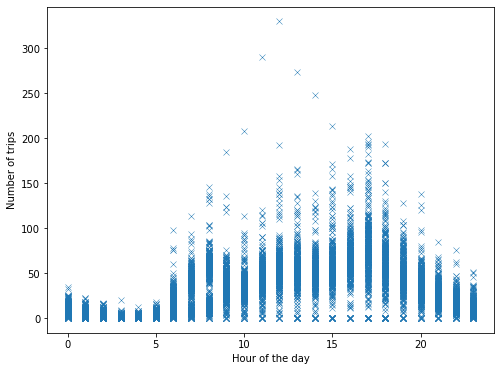

In [6]:
# non-linear relationship
plt.figure(figsize=(8,6))
sns.scatterplot(data=feature_data, x="hour", y="trips", marker="x")
plt.xlabel("Hour of the day")
plt.ylabel("Number of trips")
plt.show()

In [7]:
def plot_Poly_regression(X,Y,d):
    
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Trips")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.5063156380175526


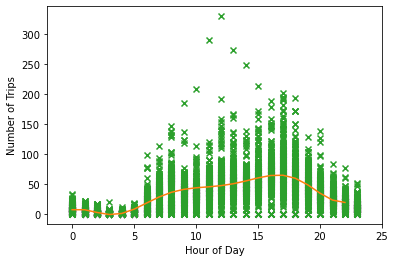

In [8]:
plot_Poly_regression(X =feature_data["hour"].values, Y=feature_data["trips"].values, d = 11)


highest R^2 is achieved with d=11

what is the effect of normalization of features

In [9]:
def plot_regression_poly_norm(X,Y,d):
    
    
    # Polynomial model:
    poly_reg = PolynomialFeatures (degree = d)
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    #Normalizing features:
    lin_reg_2 = LinearRegression(normalize = True)
    lin_reg_2.fit(x_poly, Y)
    model_pred = lin_reg_2.predict(x_poly)
    
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_2.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Trips")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_2.coef_)

The R^2 for quadratic curve is:  0.5072244310382394


/Users/stefaniemarx/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


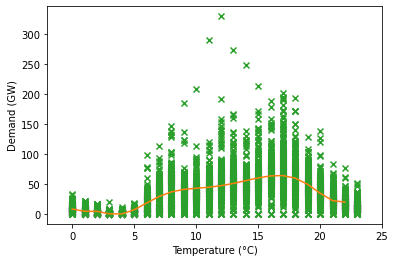

In [11]:
plot_regression_poly_norm(X =feature_data["hour"].values, Y=feature_data["trips"].values, d = 11)

## Cross validation
70% of the data "new" training set, 30% holdout or validation set. 

In [24]:
# split the data with 70% in each set
X_train, X_test, y_train, y_test = train_test_split(feature_data["hour"].values, feature_data["trips"].values, test_size=0.3)

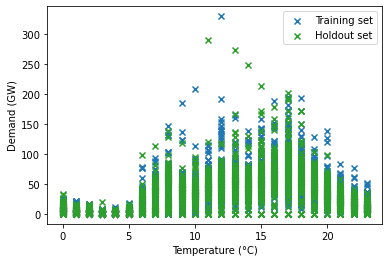

In [25]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])

In [26]:
# fit the model on one set of data

poly_reg = PolynomialFeatures (degree = 6)
x_poly = poly_reg.fit_transform(X_train.reshape(-1,1))

model = LinearRegression(normalize = True)
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(X_test.reshape(-1,1)))
print ('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))

The R^2 for quadratic curve is:  0.4784925799682255


/Users/stefaniemarx/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


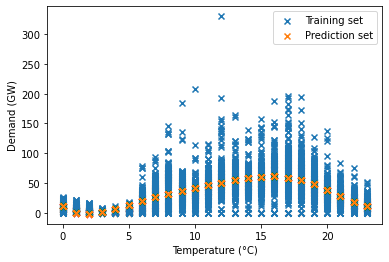

In [27]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_pred, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Prediction set'])

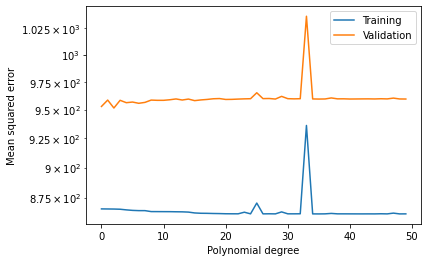

In [28]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
#plt.savefig('crossvalidation error .png', dpi = 500)

## Regularization

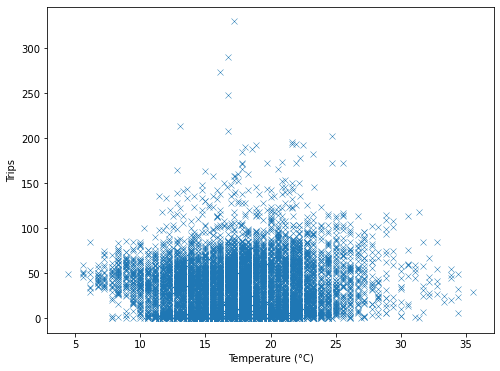

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=feature_data, x="max_temp", y="trips", marker="x")
plt.xlabel("Temperature (°C)")
plt.ylabel("Trips")
plt.show()

The R^2 for quadratic curve is:  0.02126135654853145


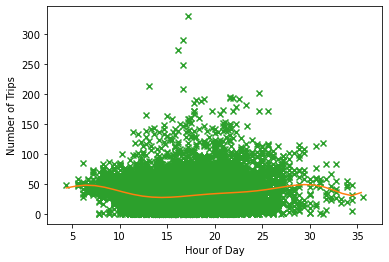

In [15]:
plot_Poly_regression(X =feature_data["max_temp"].values, Y=feature_data["trips"].values, d = 8)
